In [1]:
import librosa as lr
import numpy as np
import numpy
import decimal
import math
import soundfile as sf
import matplotlib.pyplot as plt
from pystoi import stoi
from pypesq import pesq
from scipy import signal

# base.py
def fbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
          nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
          winfunc=lambda x:numpy.ones((x,))):
    """Compute Mel-filterbank energy features from an audio signal.

    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use numpy window functions here e.g. winfunc=numpy.hamming
    :returns: 2 values. The first is a numpy array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector. The
        second return value is the energy in each frame (total energy, unwindowed)
    """
    highfreq= highfreq or samplerate/2
    signal = preemphasis(signal,preemph)
    frames = framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = powspec(frames,nfft)
    energy = numpy.sum(pspec,1) # this stores the total energy in each frame
    energy = numpy.where(energy == 0,numpy.finfo(float).eps,energy) # if energy is zero, we get problems with log

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    feat = numpy.where(feat == 0,numpy.finfo(float).eps,feat) # if feat is zero, we get problems with log
    return feat,energy


def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)

    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the sample rate of the signal we are working with, in Hz. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = lr.hz_to_mel(lowfreq)
    highmel = lr.hz_to_mel(highfreq)
    melpoints = numpy.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = numpy.floor((nfft+1)*lr.mel_to_hz(melpoints)/samplerate)

    fbank = numpy.zeros([nfilt,nfft//2+1])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

# sigproc.py 
def preemphasis(signal, coeff=0.95):
    """perform preemphasis on the input signal.

    :param signal: The signal to filter.
    :param coeff: The preemphasis coefficient. 0 is no filter, default is 0.95.
    :returns: the filtered signal.
    """
    return numpy.append(signal[0], signal[1:] - coeff * signal[:-1])


def framesig(sig, frame_len, frame_step, winfunc=lambda x: numpy.ones((x,)), stride_trick=True):
    """Frame a signal into overlapping frames.

    :param sig: the audio signal to frame.
    :param frame_len: length of each frame measured in samples.
    :param frame_step: number of samples after the start of the previous frame that the next frame should begin.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied.
    :param stride_trick: use stride trick to compute the rolling window and window multiplication faster
    :returns: an array of frames. Size is NUMFRAMES by frame_len.
    """
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step))

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = numpy.zeros((padlen - slen,))
    padsignal = numpy.concatenate((sig, zeros))
    if stride_trick:
        win = winfunc(frame_len)
        frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    else:
        indices = numpy.tile(numpy.arange(0, frame_len), (numframes, 1)) + numpy.tile(
            numpy.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
        indices = numpy.array(indices, dtype=numpy.int32)
        frames = padsignal[indices]
        win = numpy.tile(winfunc(frame_len), (numframes, 1))

    return frames * win


def powspec(frames, NFFT):
    """Compute the power spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).

    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the power spectrum of the corresponding frame.
    """
    return 1.0 / NFFT * numpy.square(magspec(frames, NFFT))
    #return 1.0 / NFFT * magspec(frames, NFFT)


def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))


def rolling_window(a, window, step=1):
    # http://ellisvalentiner.com/post/2017-03-21-np-strides-trick
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return numpy.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step]


def magspec(frames, NFFT):
    """Compute the magnitude spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1).

    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded.
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the magnitude spectrum of the corresponding frame.
    """
    if numpy.shape(frames)[1] > NFFT:
        logging.warn(
            'frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.',
            numpy.shape(frames)[1], NFFT)
    complex_spec = numpy.fft.rfft(frames, NFFT)
    return numpy.absolute(complex_spec)


# gen_dataset.py 
def get_mel_scale(nfilt=20, samplerate=16000, lowfreq=20, highfreq=8000):
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"
    # compute points evenly spaced in mels
    lowmel = lr.hz_to_mel(lowfreq)
    highmel = lr.hz_to_mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    return melpoints


def iir_design(band_frequency, samplerate, order=1): # the ban frequency is the middel fre
    b = []
    a = []
    fre = band_frequency / (samplerate/2)
    for i in range(1, len(band_frequency)-1):
        b_, a_ = signal.iirfilter(order, [fre[i] - (fre[i]-fre[i-1])/2, fre[i]+ (fre[i+1]-fre[i])/2],
                                  btype='bandpass', output='ba')
        # b_, a_ = signal.iirfilter(order, [fre[i-1], fre[i+1]-0.001],
        #                            btype='bandpass', output='ba')
        # b_, a_ = signal.cheby1(order, 1, [fre[i] - (fre[i]-fre[i-1])/2, fre[i]+ (fre[i+1]-fre[i])/2],
        #                           btype='bandpass', output='ba')
        b.append(b_)
        a.append(a_)
    return b, a


def bandpass_filter_iir(sig, b_in, a_in, step, gains):
    x = sig
    y = np.zeros(len(x))
    state = np.zeros(len(b_in)-1)
    g=0
    for n in range(0, len(gains)):
        g = max(0.6*g, gains[n])    # r=0.6 pre RNNoise paper https://arxiv.org/pdf/1709.08243.pdf
        b = b_in*g
        a = a_in
        filtered, state = signal.lfilter(b, a, x[n*step: min((n+1)*step, len(x))], zi=state)
        y[n*step: min((n+1)*step, len(x))] = filtered
    return y


# evaluation
def stoi_wrapper(ref, denoised, sr, extension = True):
    """
    Computes the intelligibility score based on the STOI predictor.

    Based on: C. H. Taal, R. C. Hendriks, R. Heusdens, and J. Jensen, 
    "A Short-Time Objective Intelligibility Measure for Time-Frequency Weighted Noisy
    Speech", IEEE Int. Conf. Acoust., Speech, Signal Processing, Dallas, United States,
    pp. 4214-4217, 2010.

    Signals are resampled to 10kHz by the stoi method if sr != 10000.

    Parameters:
    -----------
    ref (1D ndarray): clean signal
    denoised (1D ndarray): restored signal, i.e, denoised.
    sr (float): sampling frequency 
    extension (str): True extends the STOI score for non-linearly processed input signals
        such as time-frequency masking operations.

    Returns:
    --------
    float: estimated intelligibility score in [0, 100]


    Calls: None

    """

    d = stoi(ref, denoised, sr, extended = extension)
    return 100 / (1 + np.exp(-13.1903 * d + 6.5192))


def pesq_wrapper(ref, denoised, sr, mode = 'nb'):
    """
    Computes an estimation of the MOS-LQO score based on raw PESQ scores.

    The implementation is taken from the github repo pypesq. Sampling frequency 
    should be either 8k or 16k. It is not consistent with the results provided
    by pesq_ITU_wrapper.

    Parameters:
    -----------
    ref (1D ndarray): clean signal
    denoised (1D ndarray): restored signal, i.e, denoised.
    sr (float): sampling frequency; either 8k for narrowband or 16k for wideband
    mode (str): either 'nb' or 'wb' for narrow- and wide-band respectively.

    Returns:
    --------
    float: estimated MOS-LQO score. Rescaling of [-0.5, 4.5] raw MOS scores to 
        a range of [1.02, 4.56] for MOS-LQO scores.


    Calls: None

    """
    
    p = pesq(ref, denoised, sr) # Raw scores in [-0.5, 4.5]
    # mapping to MOS-LQO
    # return p
    return 0.999 + (4.999 - 0.999) / (1 + np.exp(-1.4945 * p + 4.6607))

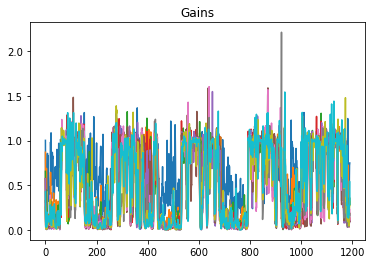

band frequency [ 121.05437772  222.10875545  323.16313317  424.21751089  525.27188862
  626.32626634  727.38064406  828.43502179  929.48939951 1032.00043091
 1145.3543967  1271.15905646 1410.78198285 1565.74096137 1737.72048971
 1928.59008921 2140.42462768 2375.52687448 2636.45253302 2926.03802278
 3247.43131291 3604.12614258]
denoising using IIR filter
b [array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03818854,  0.        , -0.03818854]), array([ 0.03845347,  0.        , -0.03845347]), array([ 0.04068493,  0.        , -0.04068493]), array([ 0.04488399,  0.        , -0.04488399]), array([ 0.04957766,  0.        , -0.04957766]), array([ 0.05473609,  0.        , -0.05473609]), array([ 0.0603998

In [2]:
nfilt = 22
sampling_rate = 8_000

clean_file = "_clean_sample.wav"
noisy_file = "_noisy_sample.wav"

clean_sig, _ = lr.load(clean_file, sr=sampling_rate)
noisy_sig, _ = lr.load(noisy_file, sr=sampling_rate)

#clean_sig = clean_sig/32768
#noisy_sig = noisy_sig/32768

# Calculate the energy of each frequency bands
clean_band_eng, _ = fbank(clean_sig, sampling_rate, winlen=0.02, winstep=0.02/2, nfilt=nfilt, nfft=512, lowfreq=20, highfreq=4000, preemph=0)
noisy_band_eng, _ = fbank(noisy_sig, sampling_rate, winlen=0.02, winstep=0.02/2, nfilt=nfilt, nfft=512, lowfreq=20, highfreq=4000, preemph=0)
# gains
gains = np.sqrt(clean_band_eng / noisy_band_eng)
plt.title("Gains")
plt.plot(gains[:, :10])
plt.show()

# convert mel scale back to frequency band
mel_scale = get_mel_scale(nfilt=nfilt, lowfreq=20, highfreq=4000)
band_freq = lr.mel_to_hz(mel_scale)
band_frequency = band_freq[1:-1] # the middle point of each band
print('band frequency', band_frequency)

print("denoising using IIR filter")
b, a = iir_design(band_freq, sampling_rate)

print("b", b)
print("a", a)
step = int(0.02 / 2 * sampling_rate)
print("audio process step:", step)
filtered_signal = np.zeros(len(noisy_sig))
for i in range(len(b)):
    filtered_signal += bandpass_filter_iir(noisy_sig, b[i].copy(), a[i].copy(), step, gains[:, i])
    print("filtering with frequency: ", band_frequency[i])
filtered_signal = filtered_signal * 0.6

filtered_signal = np.clip(filtered_signal, -1, 1)
sf.write("NEW_filtered_sample.wav", np.asarray(filtered_signal * 32767, dtype=np.int16), sampling_rate)
sf.write("NEW_noisy_sample.wav", np.asarray(noisy_sig * 32767, dtype=np.int16), sampling_rate)
sf.write("NEW_clean_sample.wav", np.asarray(clean_sig * 32767, dtype=np.int16), sampling_rate)
print("noisy signal is saved to:", "NEW_noisy_sample.wav")
print("filtered signal is saved to:", "NEW_filtered_sample.wav")
print("clean signal is saved to:", "NEW_clean_sample.wav")

In [3]:
x, rate = lr.load("NEW_clean_sample.wav", sr=8000)
x = np.asarray(x * 32767, dtype=np.int16)

fs, _ = lr.load("NEW_filtered_sample.wav", sr=8000)
# fs, _ = lr.load("_nn_filtered_sample_old.wav", sr=16000)
fs = np.asarray(fs * 32767, dtype=np.int16)

mos_lqo1 = pesq_wrapper(ref=x, denoised=fs, sr=rate, mode='nb')
stoi1 = stoi_wrapper(ref=x, denoised=fs, sr=rate)
print('mos_lqo: ', mos_lqo1)
print('stoi: ', stoi1)

# Ground truth gains denoising
# mos_lqo:  2.891649389674194
# stoi:  98.63865325762362

# Noisy sample
# mos_lqo:  2.346717881790833
# stoi:  96.18188215058063

# Original pipeline
# mos_lqo:  
# stoi:  

# My pipeline
# mos_lqo:  
# stoi:  